### Задача
Команда ML сделала некоторые новые алгоритмы рекомендаций новостей в ленте одной соцсети. Ожидается, что новые алгоритмы сделают пользователей счастливее (удлинится LTV, повысятся денежные конверсии и т.д.), а продукт удобнее/приятнее в использовании. Необходимо проверить эту гипотезу.

Сделано два новых алгоритма рекомендаций:
1. Показываем пользователю посты, наиболее похожие на те, которые он лайкал.
2. Показываем пользователю посты, которые лайкали похожие на него пользователи.

### Решение

Во-первых, определим показатель, увеличение которого будет говорить, что посты действительно стали интереснее. Возможные варианты:
1. Время, проведенное в ленте
2. Количество просмотренных постов в единицу времени
3. Количество лайков
4. CTR из просмотров в лайки

Остановимся на CTR, т.к. это явное действие, которое показывает заинтересованность – лайк. Кроме того это довольно стандартная метрика, понятная и простая в расчетах.

Во-вторых, проверим, корректно ли проведено сплитование юзеров на группы.

В-третьих, проведем сам A/B тест и сделаем вывод о полезности новых алгоритмов.

#### A/A тест
Для проведение необходимо разбить пользователей на группы, исходя из условий:
1. Разбиение случайно
2. У каждого пользователя в течение эксперимента группа не менялась
3. Способ разбиения должен быть детерминированным (чтобы можно было, если нужно, в точности повторить разбиение)

 Стандартная техника для разбиения — хеширование с солью.

In [2]:
# функция хэширования с солью со сплитом на 5 групп.

def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

В данном проекте разбиение на группы уже проведено (колонка exp_group). Посмотрим на данные.

In [78]:
import pandas as pd
import numpy as np
import random
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv('feed.csv')

In [15]:
df.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,3011,1283,view,2022-12-25 00:00:00,1,27,Russia,Moscow,iOS,ads,4
1,11066,1398,like,2022-12-25 00:00:00,0,20,Russia,Tomsk,Android,ads,3
2,14843,1454,like,2022-12-25 00:00:00,0,20,Russia,Kaluga,Android,ads,3
3,15938,1378,view,2022-12-25 00:00:00,1,19,Russia,Moscow,Android,ads,1
4,1725,1507,view,2022-12-25 00:00:01,1,19,Ukraine,Kovel,Android,ads,4


In [16]:
df['time'] = pd.to_datetime(df['time'])

Нужно проверить, что система сплитования корректно бьет пользователей на группы, то есть размеры групп примерно одинаковые и показатели в них сами по себе не различаются

In [8]:
groups = df.groupby('exp_group', as_index = False)\
    .agg({'user_id':'count'})

groups

,exp_group,user_id
0,0,758979
1,1,761415
2,2,754958
3,3,768729
4,4,763320


Видим, что есть 5 групп, во всех группах примерно одинаковое количество юзеров.

Известно, что АА тест проходил в период с '2022-12-25' по '2022-12-31'. Проведем сравнение 2 и 3 групп.

In [47]:
# создадим отдельный датафрейм с выборкой по условию
sub_df = df.query('(exp_group == 2 or exp_group == 3) & time >= "2022-12-25" & time <= "2023-01-01"')

Посчитаем CTR для каждого пользователя

In [48]:
ctr_table = sub_df.pivot_table(index='user_id', columns='action', aggfunc='size', fill_value=0).reset_index()
ctr_table['ctr'] = ctr_table.like / ctr_table.view

In [49]:
exp_group = sub_df.groupby(['user_id', 'exp_group'], as_index=False).agg({'action':'count'})
ctr_table = ctr_table.merge(exp_group, on='user_id', how='inner')

In [50]:
ctr_table.head()

,user_id,like,view,ctr,exp_group,action
0,200,12,36,0.333333,3,48
1,204,8,38,0.210526,3,46
2,207,22,61,0.360656,3,83
3,215,7,47,0.148936,3,54
4,217,11,61,0.180328,3,72


Посмотрим на распределение CTR в группах.

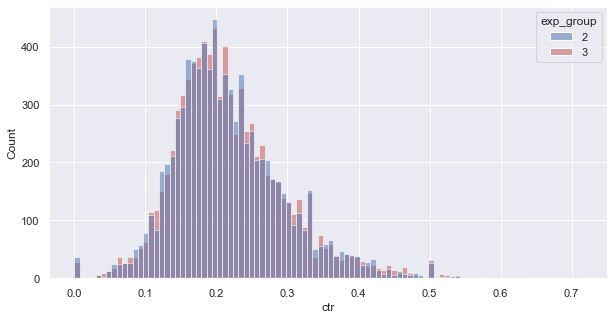

In [52]:
sns.set(rc={'figure.figsize':(10,5)})

groups = sns.histplot(data = ctr_table, 
              x='ctr', 
              hue='exp_group', 
              palette = ['b', 'r'],
              alpha=0.5,
              kde=False)

Визуально группы очень близки по распределению и среднему.

Проведем симуляцию, как будто было проведено 10000 АА-тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров. И проведем сравнение этих подвыборок t-testом.

In [53]:
#Количество симуляций
simulations = 10000

#Размер подвыборки
samples = 500

#Пустой массив для p-values
p_values = []

#Исследуемые группы
group2 = ctr_table.query('exp_group == 2').ctr.to_list()
group3 = ctr_table.query('exp_group == 3').ctr.to_list()

for i in range(simulations):
    #Генерируем случайные подвыборки без повторения
    sample2 = random.sample(group2, samples)
    sample3 = random.sample(group3, samples)

    #Проводим Т-тест
    t_test_result = ttest_ind(sample2, sample3)

    #Забираем из него значение p-value и добавляем в массив
    p_values.append(t_test_result.pvalue)

p_values = np.array(p_values)

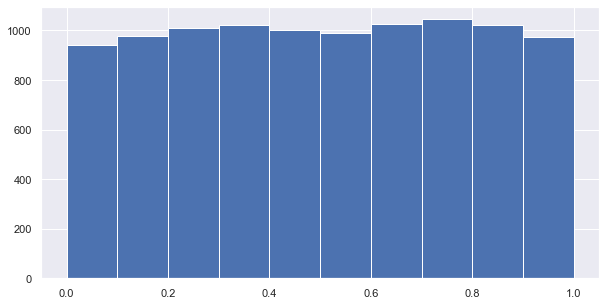

In [54]:
fig = plt.figure(figsize=(10, 5))
plt.hist(p_values)
plt.show()

In [55]:
prc = sum(p_values <= 0.05) / len(p_values) * 100
round(prc, 2)

4.74

Видим, что все p-values распределены на гистограмме практически равномерно, что может означать, что результаты теста не показывают статистически значимых различий между двумя группами. Процент p-values, меньших или равных 0.05, близок к 5%, но меньше. Это говорит о том, что нет оснований отвергнуть нулевую гипотезу о равенстве средних в группах, и что система сплитования работает корректно.

#### A/B тест

Эксперимент проходил с 2023-01-01 по 2023-01-07 включительно. Для эксперимента были задействованы 2 и 1 группы.
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [59]:
dfAB = pd.read_csv('AB.csv')

In [66]:
dfAB.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,132354,2119,view,2023-01-02 20:40:27,0,19,Russia,Ulan-Ude,Android,organic,1
1,135083,2110,view,2023-01-02 20:40:27,0,17,Russia,Kostroma,iOS,organic,1
2,16974,1973,view,2023-01-02 20:40:28,1,36,Russia,Chelyabinsk,iOS,ads,1
3,131154,1977,like,2023-01-02 20:40:28,0,20,Russia,Balakovo,Android,organic,1
4,14524,2152,view,2023-01-02 20:40:29,0,34,Russia,Kineshma,iOS,ads,2


Создадим отдельную таблицу с расчетом ctr для каждого пользователя.

In [67]:
ctr_table = dfAB.pivot_table(index='user_id', columns='action', aggfunc='size', fill_value=0).reset_index()
ctr_table['ctr'] = ctr_table.like / ctr_table.view
exp_group = dfAB.groupby(['user_id', 'exp_group'], as_index=False).agg({'action':'count'})
ctr_table = ctr_table.merge(exp_group, on='user_id', how='inner')

In [69]:
ctr_table.head()

,user_id,like,view,ctr,exp_group,action
0,206,6,38,0.157895,1,44
1,216,3,27,0.111111,1,30
2,220,14,33,0.424242,2,47
3,224,3,9,0.333333,2,12
4,227,3,29,0.103448,2,32


Посмотрим на распределение данных.

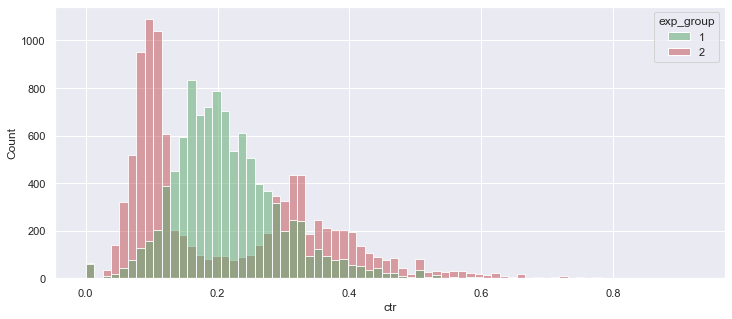

In [70]:
sns.set(rc={'figure.figsize':(12,5)})

groups = sns.histplot(data = ctr_table, 
              x='ctr', 
              hue='exp_group', 
              palette = ['g', 'r'],
              alpha=0.5,
              kde=False)

Визуально видно, что различия в группах есть. 

Кроме того, распределение ctr в группе 2 (тестовой) явно не нормальное, бимодальное. Это может говорить о том, что посты, рекомендуемые по новому алгоритму, части аудитории тестовой группы стали нравиться меьшне и их ctr упал, а другой части (как видно, меньшей по численности) - наоборот, что привелу к росту их ctr. Тут интересный момент - в результате среднее группы 2 может оказаться выше, т.е. по тестам формально ctr может и повысится. Нужно это проверить.

Также есть вопросы к дисперсиям, поэтому применение т-теста тут может быть неоправдано. Тем не менее я его проведу - любопытно посмотреть на результаты и сравнить их с другими тестами.
Затем сделаю тест Манна-Уитни и bootstrap.

In [71]:
ttest_ind(ctr_table[ctr_table.exp_group == 1].ctr,
                ctr_table[ctr_table.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270153, pvalue=0.4780623130875141)

In [74]:
mannwhitneyu(ctr_table[ctr_table.exp_group == 1].ctr, 
                   ctr_table[ctr_table.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [75]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [76]:
likes1 = ctr_table[ctr_table.exp_group == 1].like.to_numpy()
views1 = ctr_table[ctr_table.exp_group == 1].view.to_numpy()
likes2 = ctr_table[ctr_table.exp_group == 2].like.to_numpy()
views2 = ctr_table[ctr_table.exp_group == 2].view.to_numpy()

<AxesSubplot:ylabel='Count'>

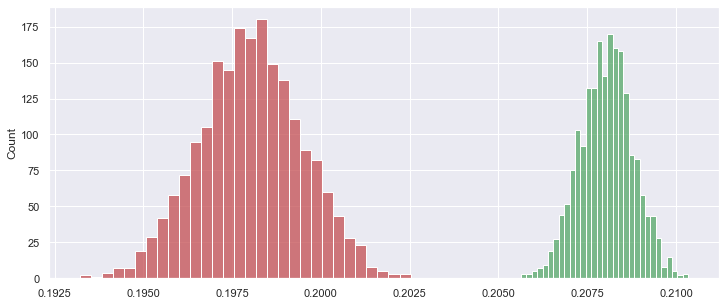

In [79]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color='g')
sns.histplot(ctr2, color='r')

<AxesSubplot:ylabel='Count'>

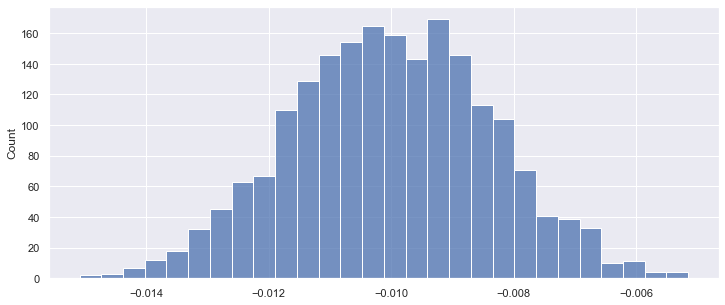

In [80]:
sns.histplot(ctr2 - ctr1)

По т-тесту и тесту Манна-Уитни видим различия в p-value. По т-тесту pvalue=0.478, т.е. значительно выше 0.05, что в принципе ожидаемо, потому т-тесту мы не верим.
Тест Манна-Уитни показал pvalue < 0.05, что оначает, что мы можем отклонить нулевую гипотезу, т.е. группы значимо различаются. Это подверждает и bootstrap - выборки средних вообще не пересекаются, их разница не проходит через ноль и отрицательна, что говорит о том, что ctr понизился.

Таким образом, нет оснований раскатывать новый алгоритм на всех новых пользователей. Однако, принимая во внимание неоднозначность распределения ctr в тестовой группе, алгоритм можно немного доработать и повторить АБ тест.